In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
import numpy as np
from copy import deepcopy

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from lib.prepare_data import get_predict_set
from lib.merge import prepare_train_show

In [2]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_renov.csv", "name": "pred_renov", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
training_renov = (
    dataframes["pred_renov"]
    .drop("DPE_consumption", "GES_emission")
    .withColumns(
        {
            "surface": (
                F.when(F.col("surface") == "null", np.nan).otherwise(
                    F.col("surface").cast("int")
                )
            ),
            "heating_production": (
                F.when(F.col("heating_production") == "null", np.nan).otherwise(
                    F.col("heating_production").cast("float")
                )
            ),
        }
    )
)
dictionary = dataframes["dictionary"]

In [8]:
training_renov = dataframes["pred_renov"].drop(
    "DPE_consumption", "GES_emission", "surface", "heating_production"
)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from scipy.stats import uniform, randint

0.9036265432098766 {'class_weight': 'balanced', 'max_depth': 8}
0.9112397119341564 {'learning_rate': 0.05263036412693078, 'n_estimators': 96}


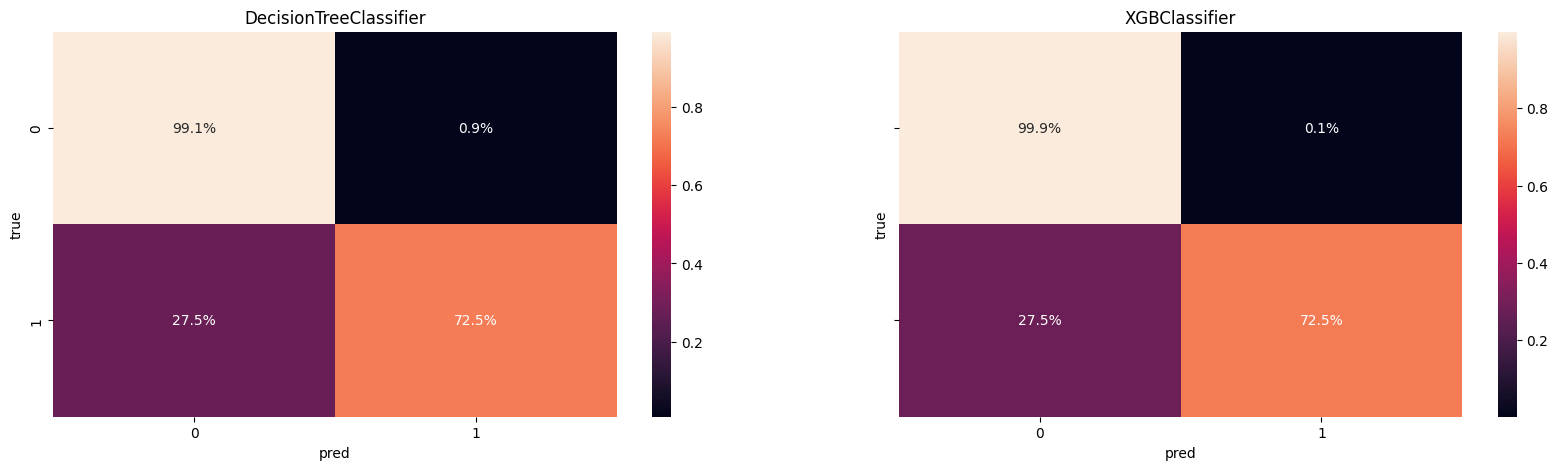

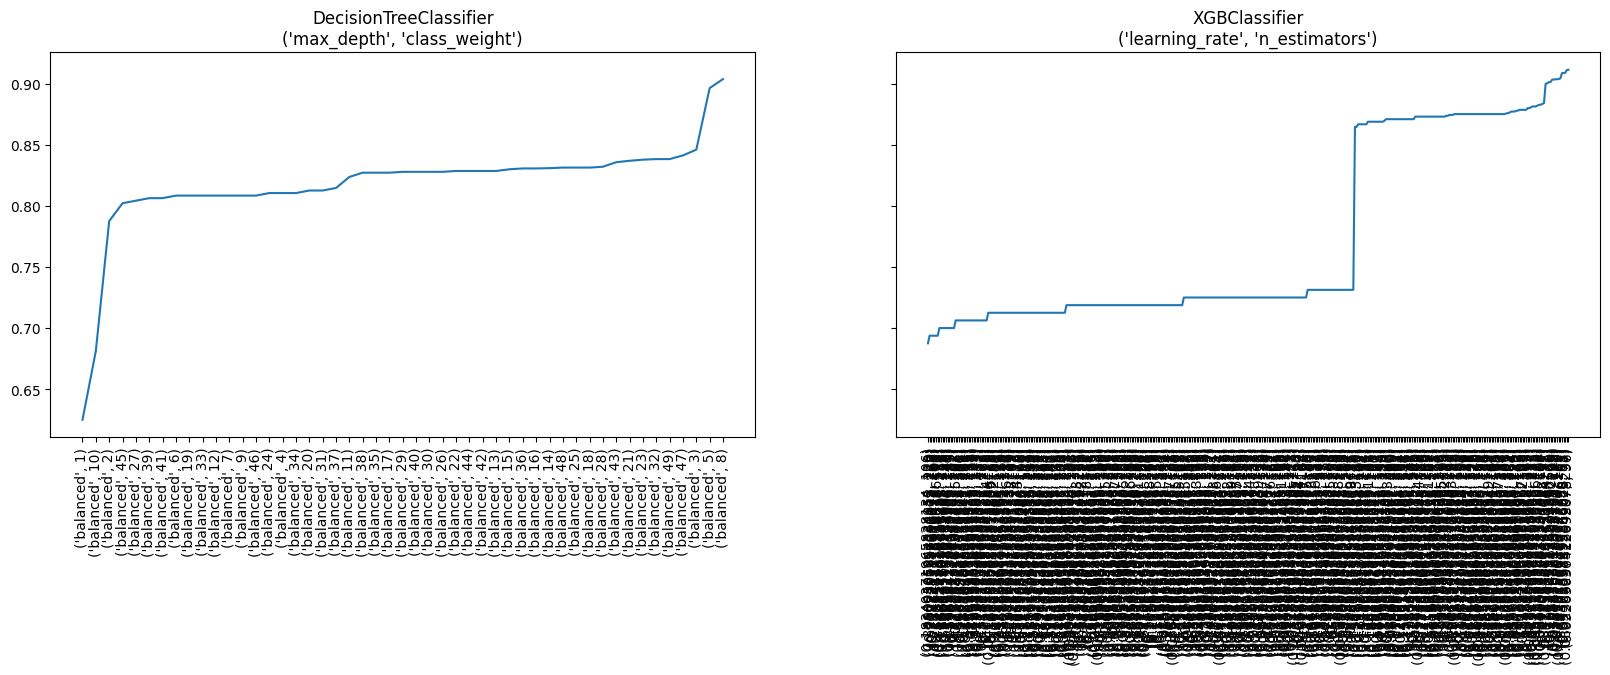

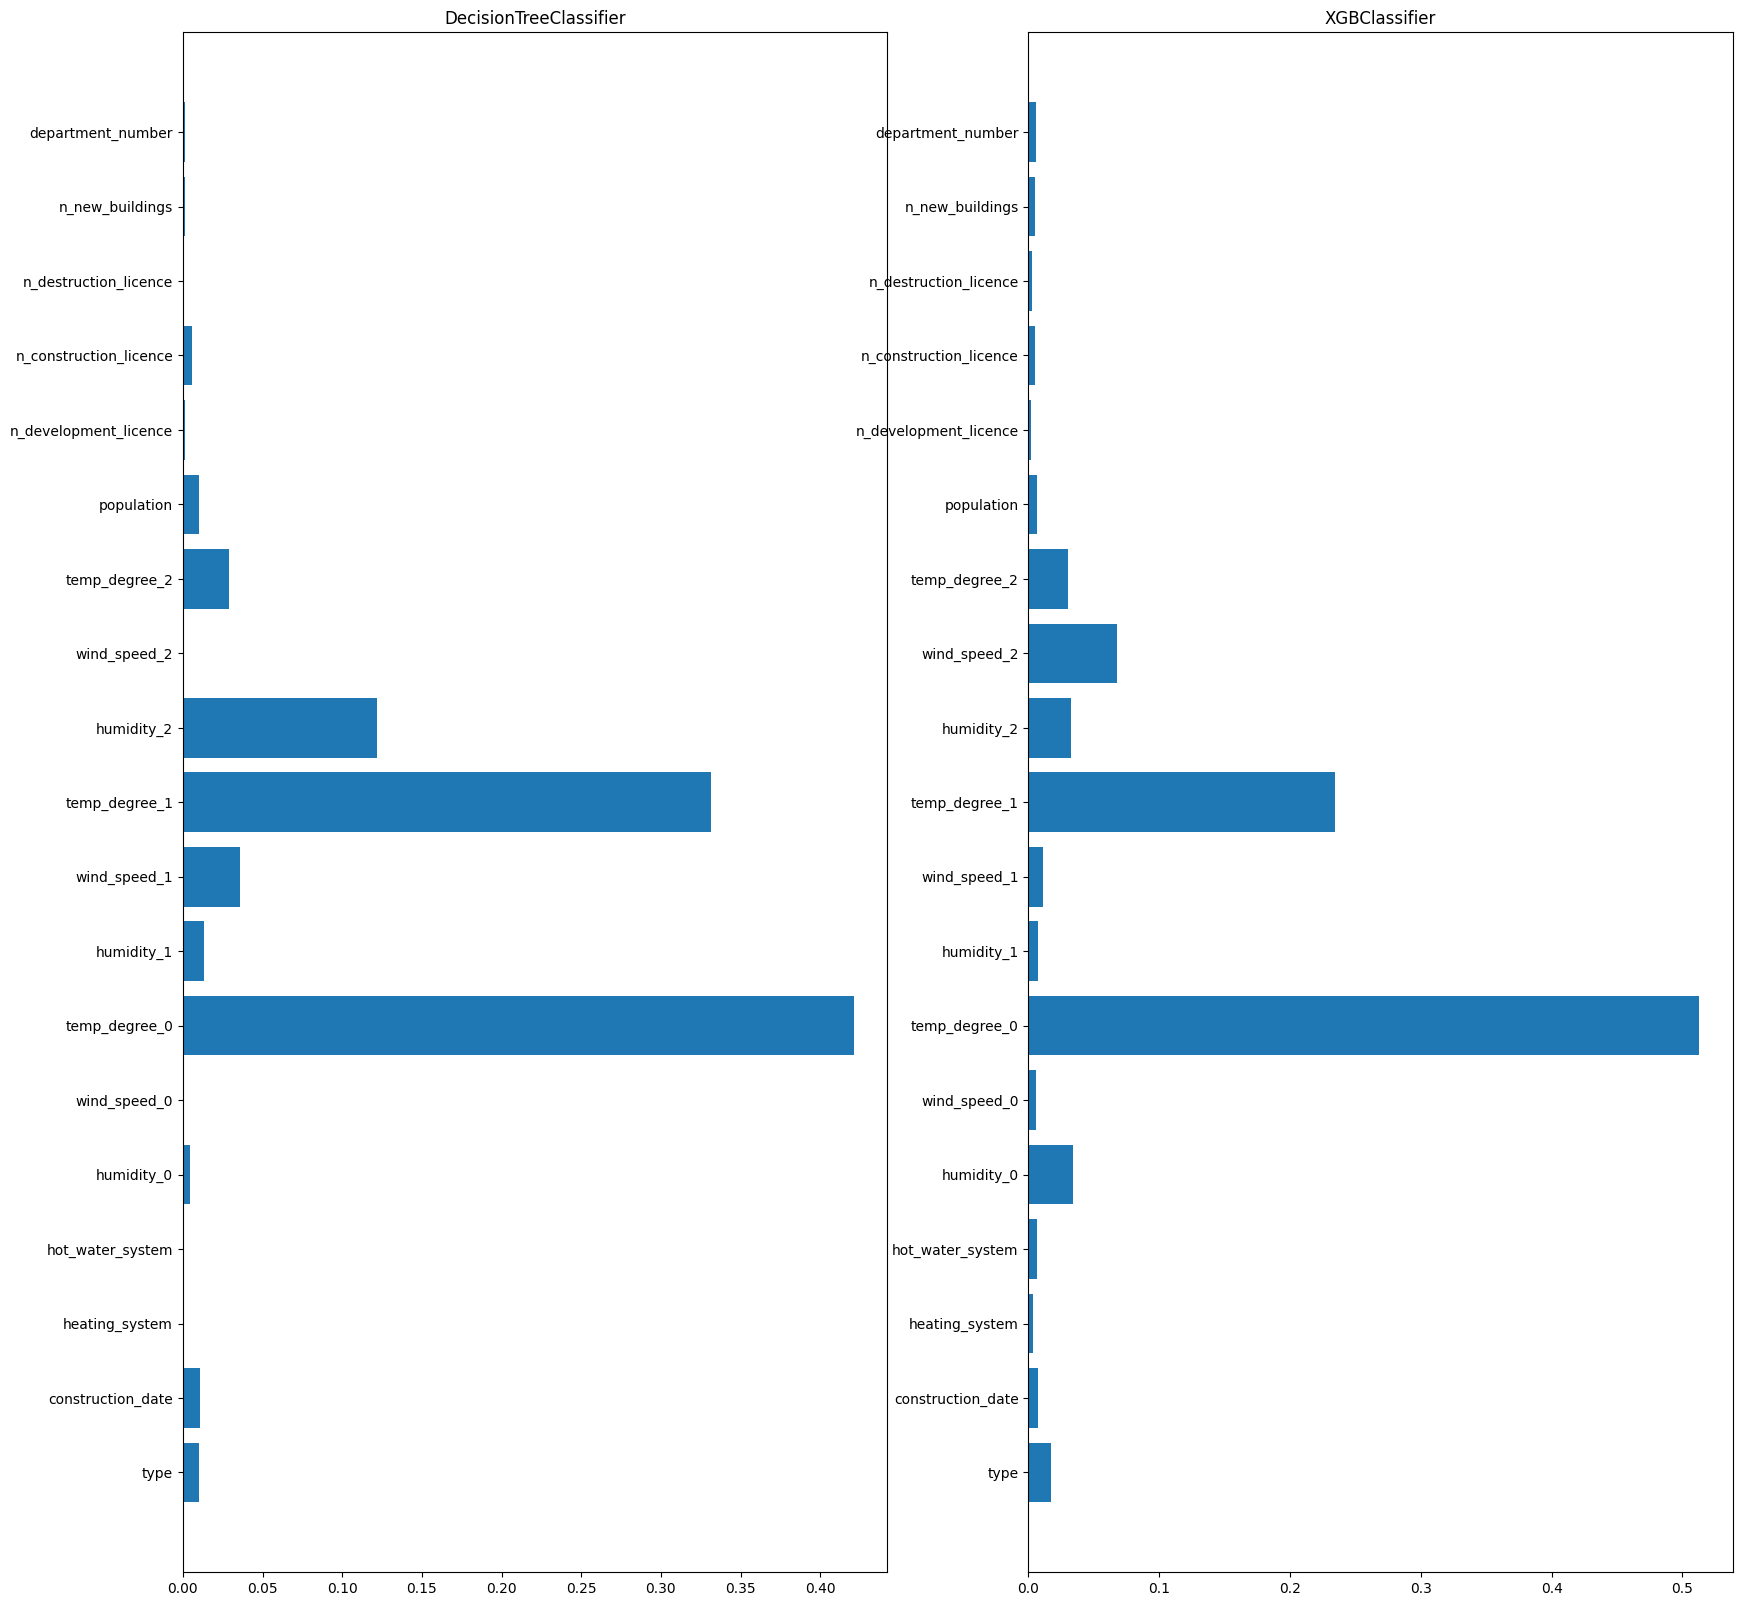

In [9]:
col_X_hot = [[], []]
col_y = ["has_done_renov"]
col_X_not_hot = [
    [col[0] for col in training_renov.dtypes if col[0] not in col_X_hot[i] + col_y]
    for i in range(len(col_X_hot))
]

categorical_features = [0, 1, 3, 4, 5, -2]


hyperparams_models = [
    {
        "max_depth": randint(1, 50),
        "class_weight": ["balanced"],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        "learning_rate": uniform(0.03, 0.3),
        "n_estimators": randint(50, 300),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
]
models = {
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "XGBClassifier": XGBClassifier,
}
best_models = prepare_train_show(
    training_renov,
    dictionary,
    categorical_features,
    col_X_hot,
    col_X_not_hot,
    col_y,
    False,
    True,
    hyperparams_models,
    models,
    random_state=42,
    test_size=0.4,
    scoring="accuracy",
)

In [7]:
training_renov.select("type", "has_done_renov").groupBy(
    "type", "has_done_renov"
).count().show()

+----+--------------+-----+
|type|has_done_renov|count|
+----+--------------+-----+
|   1|             0|10139|
|   1|             1| 3611|
|   0|             0|16757|
|   0|             1| 8991|
+----+--------------+-----+

